# Introduction

We provide a streamlined evaluation pipeline to analyze **lmgame‑Bench** results. 🎮

- **Code**: [lmgame/GamingAgent](https://github.com/lmgame-org/GamingAgent)  
- **Leaderboard**: [lmgame/game_arena_bench](https://huggingface.co/spaces/lmgame/game_arena_bench)  
- **Paper**: [LMGAME-BENCH: How Good are LLMs at Playing Games?](https://arxiv.org/abs/2505.15146)

**Contacts:**
- **Email**: largemodelgame@gmail.com
- **Discord**: [placeholder]  

---

## Evaluation Pipeline Overview

You can evaluate your model in a single run by either:
1. Using your own cache directory or cache ZIP  
2. Reusing our sample cache ZIP (default, automatic)

**Workflow**:  
Cache -> Data Preparation --> Performance Visualization --> Performance Analysis 🚀

> **Notes:**  
> 1. **Cache:** Results generated by the end-to-end GameAgent gameplay pipeline  
> 2. **Performance Visualization:** Radar charts and group bar charts  
> 3. **Performance Analysis:** Linear modeling, correlation study, and latent ability decomposition  


In [ ]:
import os
import glob
import zipfile
import requests
import json
import pandas as pd
import shutil
import gdown
import importlib
import sys

# Default constants
MODEL_PERF_RANK_URL = "https://raw.githubusercontent.com/lmgame-org/GamingAgent/refs/heads/codebase_refactor_eval_dev/eval/perf/model_perf_rank.json"
MODEL_COLORS_URL = "https://raw.githubusercontent.com/lmgame-org/GamingAgent/refs/heads/codebase_refactor_eval_dev/eval/assets/model_colors.json"
OTHER_TASK_RANK_URL = "https://raw.githubusercontent.com/lmgame-org/GamingAgent/codebase_refactor_eval_dev/eval/perf/other_task_rank.json"
DEFAULT_MODELS_FOR_OTHER_TASKS = [
    "claude-3-5-sonnet-20241022",
    "claude-3-7-sonnet-20250219",
    "gemini-2.5-pro-preview-05-06",
    "llama-4-maverick-17b-128e-instruct-fp8",
    "gpt-4o-2024-11-20",
    "o1-2024-12-17",
    "o3-2025-04-16",
    "o4-mini-2025-04-16"
]
DEFAULT_CACHE_SAMPLE_URL = "https://drive.google.com/uc?export=download&id=1uCen9DfMcKuHOyc-Lhrxa_ZeEOuWJfXM"
DEFAULT_UTILS_FUNC_URL = "https://drive.google.com/file/d/1nz6W25XnTOe5B6rtB41sloKtipqlChIh/view?usp=sharing"
TARGET_UTILS_FILE_PATH = "notebook_utils.py"
MODULE_IMPORT_NAME = "notebook_utils"

# Load all util functions
gdown.download(DEFAULT_UTILS_FUNC_URL, quiet=False, fuzzy=True)
module_dir = os.path.dirname(os.path.abspath(TARGET_UTILS_FILE_PATH))
if module_dir not in sys.path:
    sys.path.insert(0, module_dir)
    print(f"Added '{module_dir}' to sys.path (should be /content).")
if MODULE_IMPORT_NAME in sys.modules:
    print(f"Reloading module: {MODULE_IMPORT_NAME}")
    utils_module = importlib.reload(sys.modules[MODULE_IMPORT_NAME])
else:
    print(f"Importing module for the first time: {MODULE_IMPORT_NAME}")
    utils_module = importlib.import_module(MODULE_IMPORT_NAME)
exec(f"from {MODULE_IMPORT_NAME} import *")


Downloading...
From (original): https://drive.google.com/uc?id=1nz6W25XnTOe5B6rtB41sloKtipqlChIh
From (redirected): https://drive.google.com/uc?id=1nz6W25XnTOe5B6rtB41sloKtipqlChIh&confirm=t&uuid=a0a95845-6168-4b9c-889a-5badfbbf89cf
To: /content/notebook_utils.py
100%|██████████| 111k/111k [00:00<00:00, 56.6MB/s]

Reloading module: notebook_utils



# Data Preparation

We load local cache data and merge it with online benchmark data for subsequent performance visualization and analysis.


## Load Local Cache

1. **Use our provided cache sample**  
   By default, set `download_cache_sample=True` to automatically download and reuse this ZIP:
  (https://drive.google.com/file/d/1uCen9DfMcKuHOyc-Lhrxa_ZeEOuWJfXM/view?usp=drive_link).

2. **Generate your own cache**  
  Generate your own cache by cloning the [GamingAgent GitHub repository](https://github.com/lmgame-org/GamingAgent).
  ```bash
  # three lines to generate cache
  git clone https://github.com/lmgame-org/GamingAgent.git
  cd GamingAgent
 python3 lmgame-bench/run.py --model_name {model_name} --game_names {list_of_games} --harness_mode false
  ```
  Set `download_cache_sample=False` and upload your own cache directory or cache ZIP.



In [ ]:
# Adjust this flag to decide whether to download our sample cache or use a local one
download_cache_sample = False

# Step 1: Load or download cache data
if download_cache_sample:
    print("\n---------- Step 1: Download cache data ----------")
else:
    print("\n---------- Step 1: Load local cache data ----------")
file_report = check_evaluation_files(
    download_cache_sample,
    DEFAULT_CACHE_SAMPLE_URL
)

# Step 2: Generate mappings from config to log file paths
print("\n---------- Step 2: Generate config → log file path mappings ----------")
evaluation_run_map = generate_evaluation_map(file_report)

# Step 3: Extract game performance from cache files
print("\n---------- Step 3: Extract game performance from cache files ----------")
game_performance_dict = process_evaluation_run_map(evaluation_run_map)

# Show the first three entries for inspection
for i, (entry_key, entry_value) in enumerate(game_performance_dict.items(), start=1):
    print(f"\nEntry {i}:")
    print(f"  • Key   : {entry_key!r}")
    print(f"  • Value : {type(entry_value)}")
    print(entry_value)
    if i >= 3:
        break



---------- Step 1: Load local cache data ----------
Mode: Check local cache.
Info: No local cache directory 'cache' or local cache zip file 'cache.zip' found.
Final Result: No cache directory named 'cache' is available.

---------- Step 2: Generate config → log file path mappings ----------
Info: No cache directory provided in file_info. No map will be generated from cache.

---------- Step 3: Extract game performance from cache files ----------


## Integrate Online Benchmark Data with Local Data

Merge newly generated local model/game performance with existing online benchmarks for future analysis.


In [ ]:
# Step 1: Average local data of game performances
print("\n---------- Step 1: Average local data of game performances ----------")
averaged_local_data_df = convert_local_averages_to_dataframe(calculate_average_performance(game_performance_dict))
print(averaged_local_data_df.head())

# Step 2: Load online benchmark data
print("\n---------- Step 2: Load online benchmark data ----------")
benchmark_data_df = load_and_average_benchmark_rank_data(MODEL_PERF_RANK_URL)
print(benchmark_data_df.head())

# Step 3: Update online benchmark data with local data
print("\n---------- Step 3: Update online benchmark data with local data ----------")
updated_benchmark_data_df = combine_and_update_averages(benchmark_data_df, averaged_local_data_df)
print(updated_benchmark_data_df.head(10))



---------- Step 1: Average local data of game performances ----------
Empty DataFrame
Columns: [model_name, harness, game_name, avg_score_from_rank]
Index: []

---------- Step 2: Load online benchmark data ----------
Attempting to download benchmark data from: https://raw.githubusercontent.com/lmgame-org/GamingAgent/refs/heads/codebase_refactor_eval_dev/eval/perf/model_perf_rank.json
Benchmark data successfully downloaded and parsed.
Created DataFrame from benchmark rank averages with 182 rows.
                 model_name  harness           game_name avg_score_from_rank
0  Qwen3-235B-A22B-fp8-tput     True             sokoban            2.333333
1  Qwen3-235B-A22B-fp8-tput     True    super_mario_bros                <NA>
2  Qwen3-235B-A22B-fp8-tput     True              tetris           11.666667
3  Qwen3-235B-A22B-fp8-tput     True  twenty_forty_eight              2144.0
4  Qwen3-235B-A22B-fp8-tput     True         candy_crush          363.333333

---------- Step 3: Update online ben

# Game Performance Visualization

Visualize model performance across games using radar charts and grouped bar charts.

**Plot Initialization:**
- Use `show_games` and `show_models` to select which games and models are plotted.
- By default, `highlight_models` will emphasize models from the local cache data.


In [ ]:
# Specify which games and models to display in the plots
show_games = ['sokoban', 'tetris', 'twenty_forty_eight', 'candy_crush', 'super_mario_bros']
show_models = [
    'o3-2025-04-16',
    'o4-mini-2025-04-16',
    'llama-4-maverick-17b-128e-instruct-fp8',
    'gemini-2.5-pro-preview-05-06',
    'gemini-2.5-flash-preview-04-17',
    'claude-3-7-sonnet-20250219',
    'claude-3-5-sonnet-20241022'
]

highlight_models = ["deepSeek-r1-0528","Qwen3-235B-A22B-fp8-tput"]
if averaged_local_data_df is not None and highlight_models == []:
    highlight_models = list(averaged_local_data_df['model_name'].unique())

show_models += highlight_models

# Print out the `show_games`, `show_models`, and `highlight_models`
print(f"Models to highlight: {highlight_models}")
print(f"Games to show: {show_games}")
print(f"Models to show: {show_models}")

Models to highlight: ['deepSeek-r1-0528', 'Qwen3-235B-A22B-fp8-tput']
Games to show: ['sokoban', 'tetris', 'twenty_forty_eight', 'candy_crush', 'super_mario_bros']
Models to show: ['o3-2025-04-16', 'o4-mini-2025-04-16', 'llama-4-maverick-17b-128e-instruct-fp8', 'gemini-2.5-pro-preview-05-06', 'gemini-2.5-flash-preview-04-17', 'claude-3-7-sonnet-20250219', 'claude-3-5-sonnet-20241022', 'deepSeek-r1-0528', 'Qwen3-235B-A22B-fp8-tput']


In [ ]:
import plotly.graph_objects as go
import numpy as np
import random
from typing import Dict, List, Optional

# Load model color styles
print(f"Attempting to load model colors from URL: {MODEL_COLORS_URL}")
model_colors_for_plots = {}
used_colors_from_json = set()
try:
    response = requests.get(MODEL_COLORS_URL)
    response.raise_for_status()
    model_colors_from_url = response.json()
    model_colors_for_plots.update(model_colors_from_url)
    used_colors_from_json.update(model_colors_from_url.values())
    print(f"Successfully loaded model colors from URL. {len(model_colors_for_plots)} colors loaded.")
except:
    print("Warning: Could not download model colors. Will use random colors for all models.")

all_models_in_data = updated_benchmark_data_df ['model_name'].unique()
for model_name_from_data in all_models_in_data:
  if model_name_from_data not in model_colors_for_plots:
    new_color = get_random_color(used_colors_from_json)
    model_colors_for_plots[model_name_from_data] = new_color
    used_colors_from_json.add(new_color)

# Show the first three entries for inspection
for i, (entry_key, entry_value) in enumerate(model_colors_for_plots.items(), start=1):
    print(f"\nEntry {i}:")
    print(f"  • Key   : {entry_key!r}")
    print(f"  • Value : {type(entry_value)}")
    print(entry_value)
    if i >= 3:
        break


Attempting to load model colors from URL: https://raw.githubusercontent.com/lmgame-org/GamingAgent/refs/heads/codebase_refactor_eval_dev/eval/assets/model_colors.json
Successfully loaded model colors from URL. 22 colors loaded.

Entry 1:
  • Key   : 'claude-3-7-sonnet-20250219'
  • Value : <class 'str'>
#4A90E2

Entry 2:
  • Key   : 'claude-3-5-haiku-20241022'
  • Value : <class 'str'>
#7FB5E6

Entry 3:
  • Key   : 'claude-3-5-sonnet-20241022'
  • Value : <class 'str'>
#1A4C7C


## Radar Chart & Group Bar Chart

Visualize each model’s performance across multiple games.
- **Harnessed Performance**
- **Unharnessed Performance**

### Harnessed Performance

In [ ]:
harness_boolean_val = True
harness_title_str = "Harness True"

print(f"\n--- Generating plots for {harness_title_str} ---")

df_for_plotting = prepare_dataframe_for_plots(
    source_df=updated_benchmark_data_df,
    selected_games=show_games,
    selected_models=show_models,
    harness_bool_to_use=harness_boolean_val
    )

if df_for_plotting.empty:
  print(f"No data to plot for {harness_title_str}. Skipping.")

# Create and show radar chart
fig_radar = create_comparison_radar_chart(
    df=df_for_plotting,
    model_colors=model_colors_for_plots,
    selected_games=show_games,
    harness_status_str=harness_title_str,
    highlight_models=highlight_models
    )


print(f"Displaying Radar Chart for {harness_title_str}:")
fig_radar.show()



--- Generating plots for Harness True ---
Displaying Radar Chart for Harness True:


In [ ]:
# Create and show game-specific horizontal bar charts
game_bar_figures = create_game_specific_horizontal_bar_charts(
    df=df_for_plotting,
    model_colors=model_colors_for_plots,
    selected_games=show_games,
    harness_status_str=harness_title_str,
    highlight_models=highlight_models)

for i, fig_bar in enumerate(game_bar_figures):
  game_name = show_games[i] if i < len(show_games) else f"Game {i+1}"
  print(f"Displaying Horizontal Bar Chart for {game_name} ({harness_title_str}):")
  fig_bar.show()

Displaying Horizontal Bar Chart for sokoban (Harness True):


Displaying Horizontal Bar Chart for tetris (Harness True):


Displaying Horizontal Bar Chart for twenty_forty_eight (Harness True):


Displaying Horizontal Bar Chart for candy_crush (Harness True):


Displaying Horizontal Bar Chart for super_mario_bros (Harness True):


### Unharnessed Performance

In [ ]:
harness_boolean_val = False
harness_title_str = "Harness False"

print(f"\n--- Generating plots for {harness_title_str} ---")

df_for_plotting = prepare_dataframe_for_plots(
    source_df=updated_benchmark_data_df,
    selected_games=show_games,
    selected_models=show_models,
    harness_bool_to_use=harness_boolean_val
    )

if df_for_plotting.empty:
  print(f"No data to plot for {harness_title_str}. Skipping.")

# Create and show radar chart
fig_radar = create_comparison_radar_chart(
    df=df_for_plotting,
    model_colors=model_colors_for_plots,
    selected_games=show_games,
    harness_status_str=harness_title_str,
    highlight_models=highlight_models
    )


print(f"Displaying Radar Chart for {harness_title_str}:")
fig_radar.show()




--- Generating plots for Harness False ---
Displaying Radar Chart for Harness False:


In [ ]:
# Create and show game-specific horizontal bar charts
game_bar_figures = create_game_specific_horizontal_bar_charts(
    df=df_for_plotting,
    model_colors=model_colors_for_plots,
    selected_games=show_games,
    harness_status_str=harness_title_str,
    highlight_models=highlight_models)

for i, fig_bar in enumerate(game_bar_figures):
  game_name = show_games[i] if i < len(show_games) else f"Game {i+1}"
  print(f"Displaying Horizontal Bar Chart for {game_name} ({harness_title_str}):")
  fig_bar.show()


Displaying Horizontal Bar Chart for sokoban (Harness False):


Displaying Horizontal Bar Chart for tetris (Harness False):


Displaying Horizontal Bar Chart for twenty_forty_eight (Harness False):


Displaying Horizontal Bar Chart for candy_crush (Harness False):


Displaying Horizontal Bar Chart for super_mario_bros (Harness False):


# Game Performance Analysis

We employed polynomial regression models, correlation analyses, and latent ability decomposition to examine how our benchmark relates to existing evaluations. Simultaneously, we uncovered potential latent capabilities that underlie gameplay.


## Polynomial Linear Modeling

We use polynomial regression to predict game rankings from a model’s capabilities across various categories. This analysis highlights how core AI skills—such as knowledge retrieval, puzzle solving, visual reasoning, mathematics, and coding—impact performance in specific games.

For each game, we present four regression configurations (arranged in a 2×2 grid), each combining different subsets of cognitive capabilities:

- **Comb1:** Knowledge + Puzzle + Visual + Math + Coding  
- **Comb2:** Knowledge + Visual + Math + Coding  
- **Comb3:** Language + Physics + Visual + Math + Coding  
- **Comb4:** Knowledge + Math + Coding


=== Polynomial Analysis: ace_attorney ===
  Comb1_KnowPuzVisMathCode: Error=0.8193, Categories=5
  Comb2_KnowVisMathCode: Error=0.9909, Categories=4
  Comb3_LangPhyVisMathCode: Error=0.8820, Categories=5
  Comb4_KnowMathCode: Error=0.9941, Categories=3


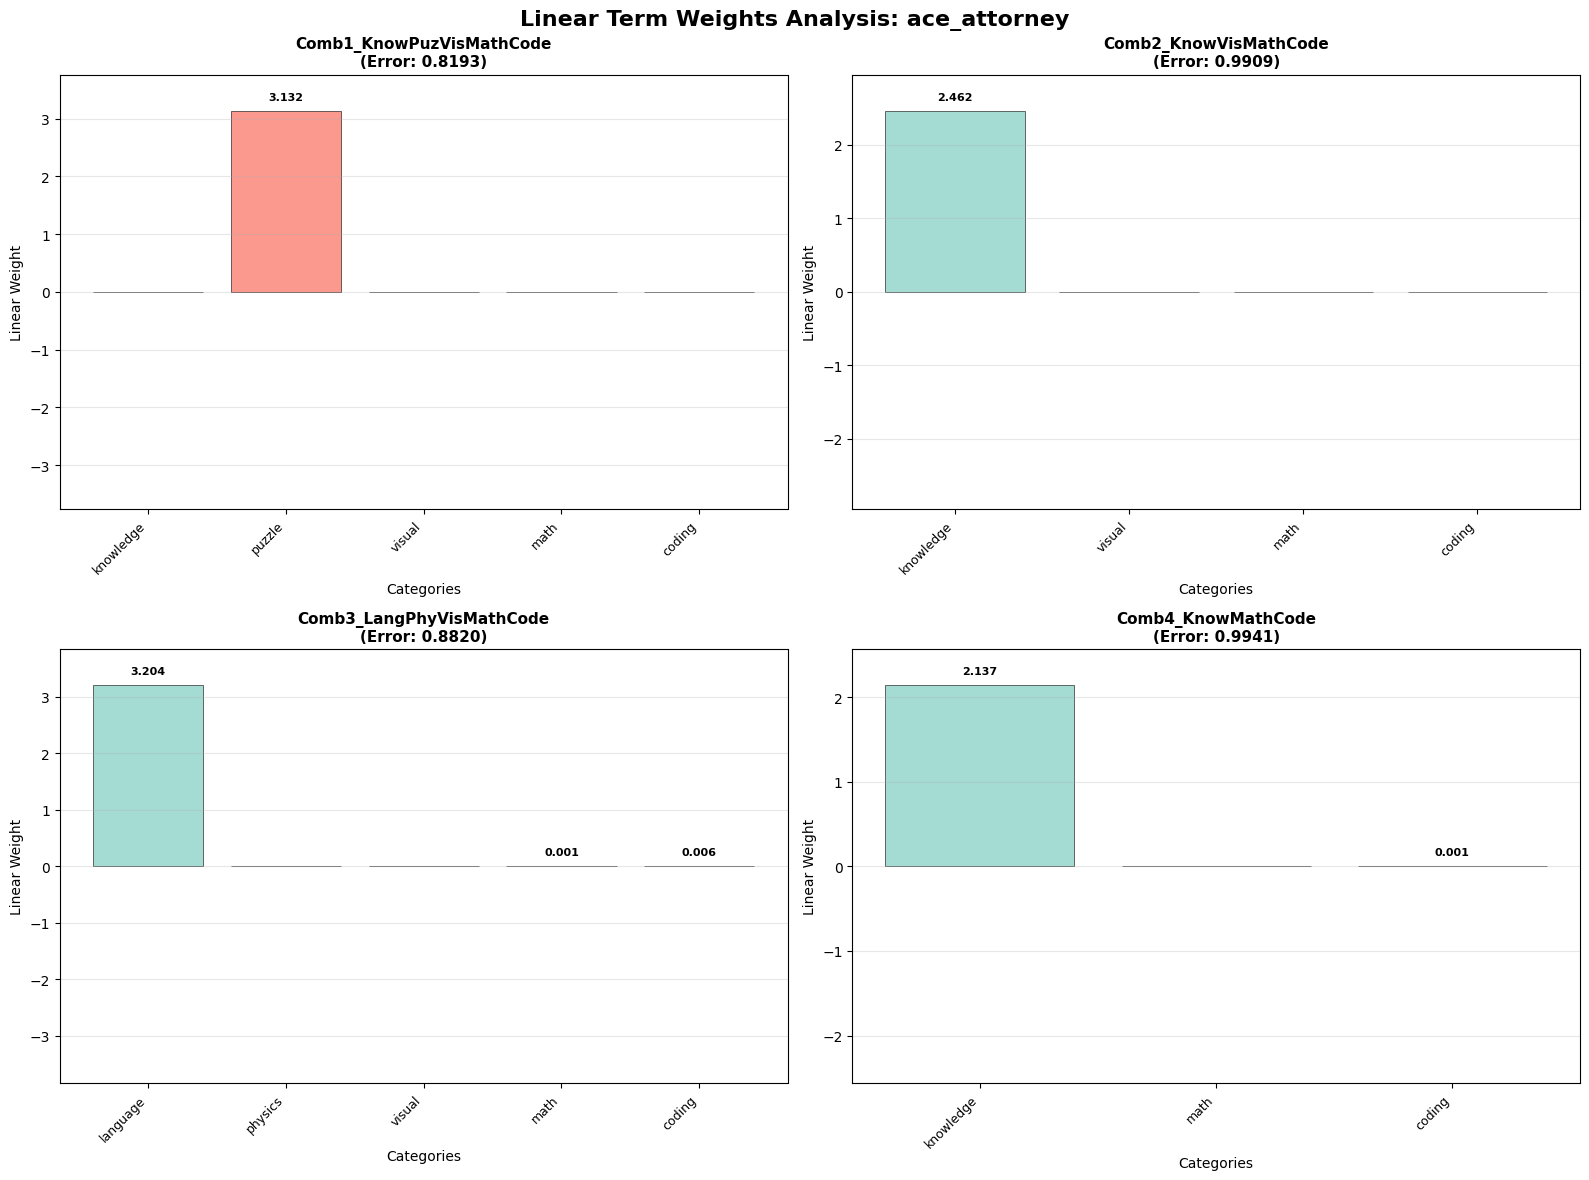

Best combination: Comb1_KnowPuzVisMathCode (Error: 0.8193)

=== Polynomial Analysis: candy_crush ===
  Comb1_KnowPuzVisMathCode: Error=0.5738, Categories=5
  Comb2_KnowVisMathCode: Error=0.6376, Categories=4
  Comb3_LangPhyVisMathCode: Error=0.4724, Categories=5
  Comb4_KnowMathCode: Error=0.6381, Categories=3


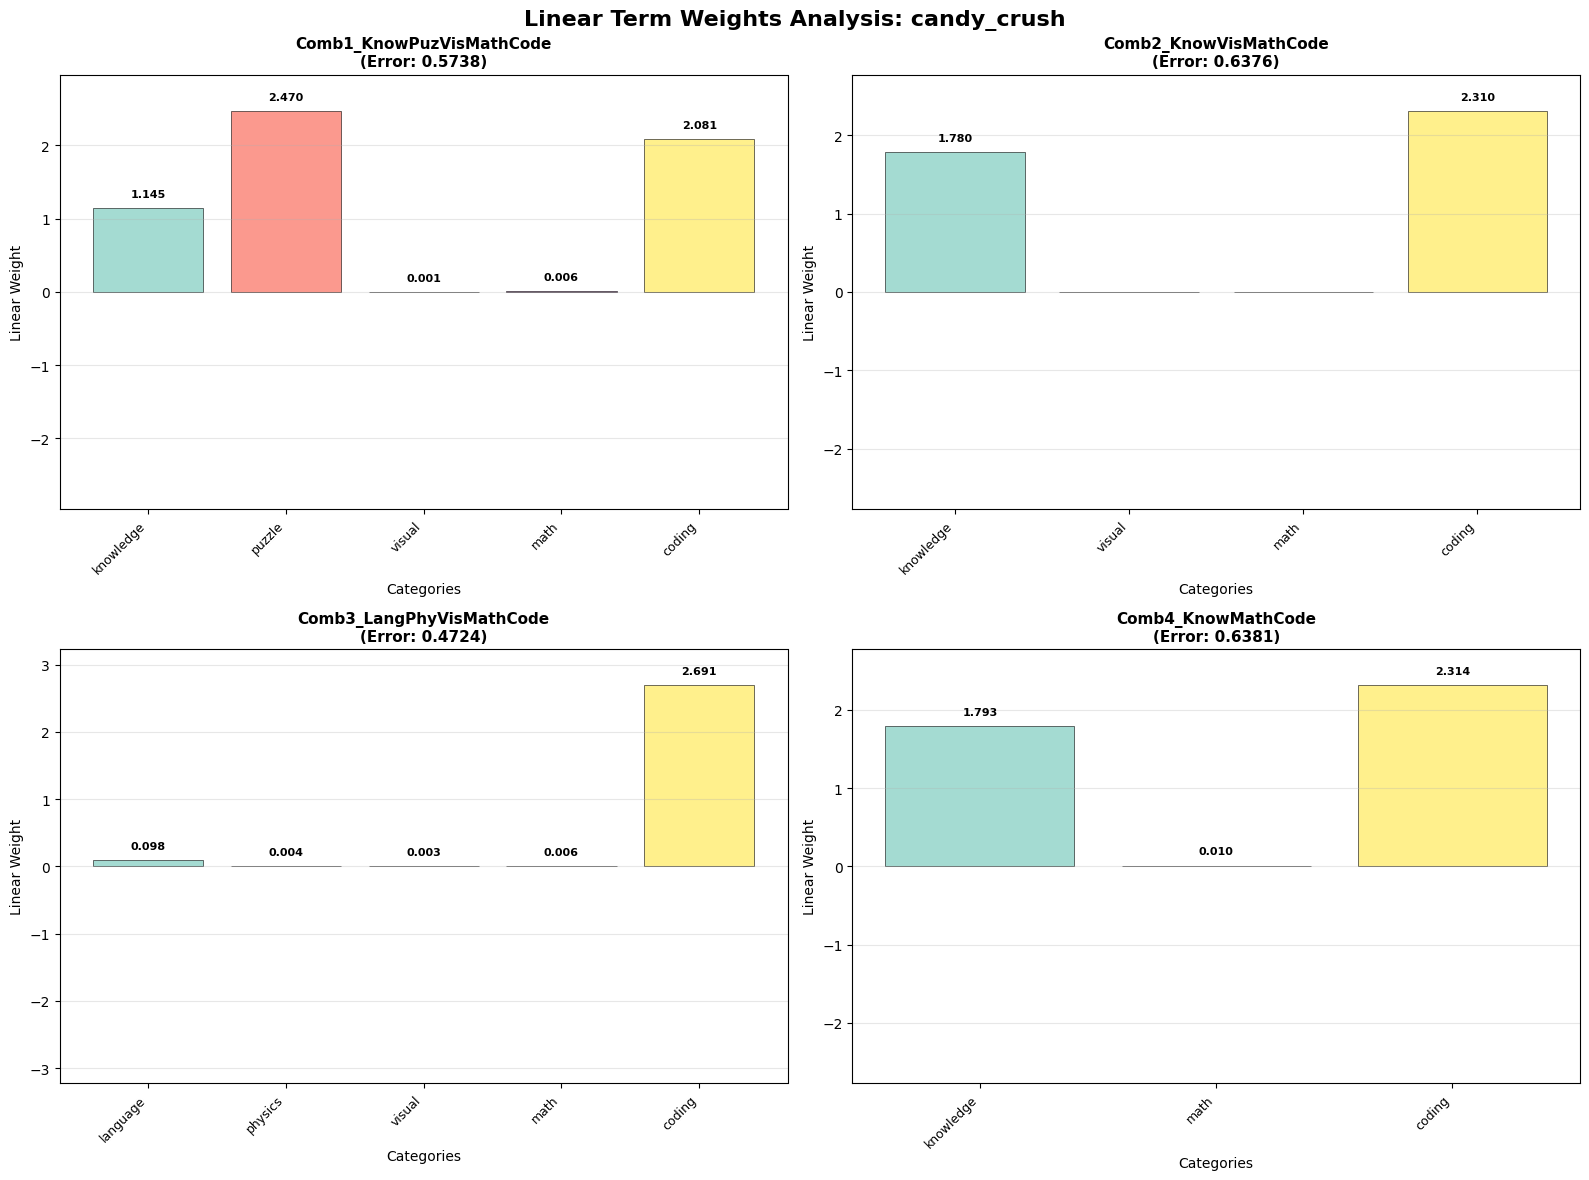

Best combination: Comb3_LangPhyVisMathCode (Error: 0.4724)

=== Polynomial Analysis: sokoban ===
  Comb1_KnowPuzVisMathCode: Error=0.2292, Categories=5
  Comb2_KnowVisMathCode: Error=0.3832, Categories=4
  Comb3_LangPhyVisMathCode: Error=0.3616, Categories=5
  Comb4_KnowMathCode: Error=0.3833, Categories=3


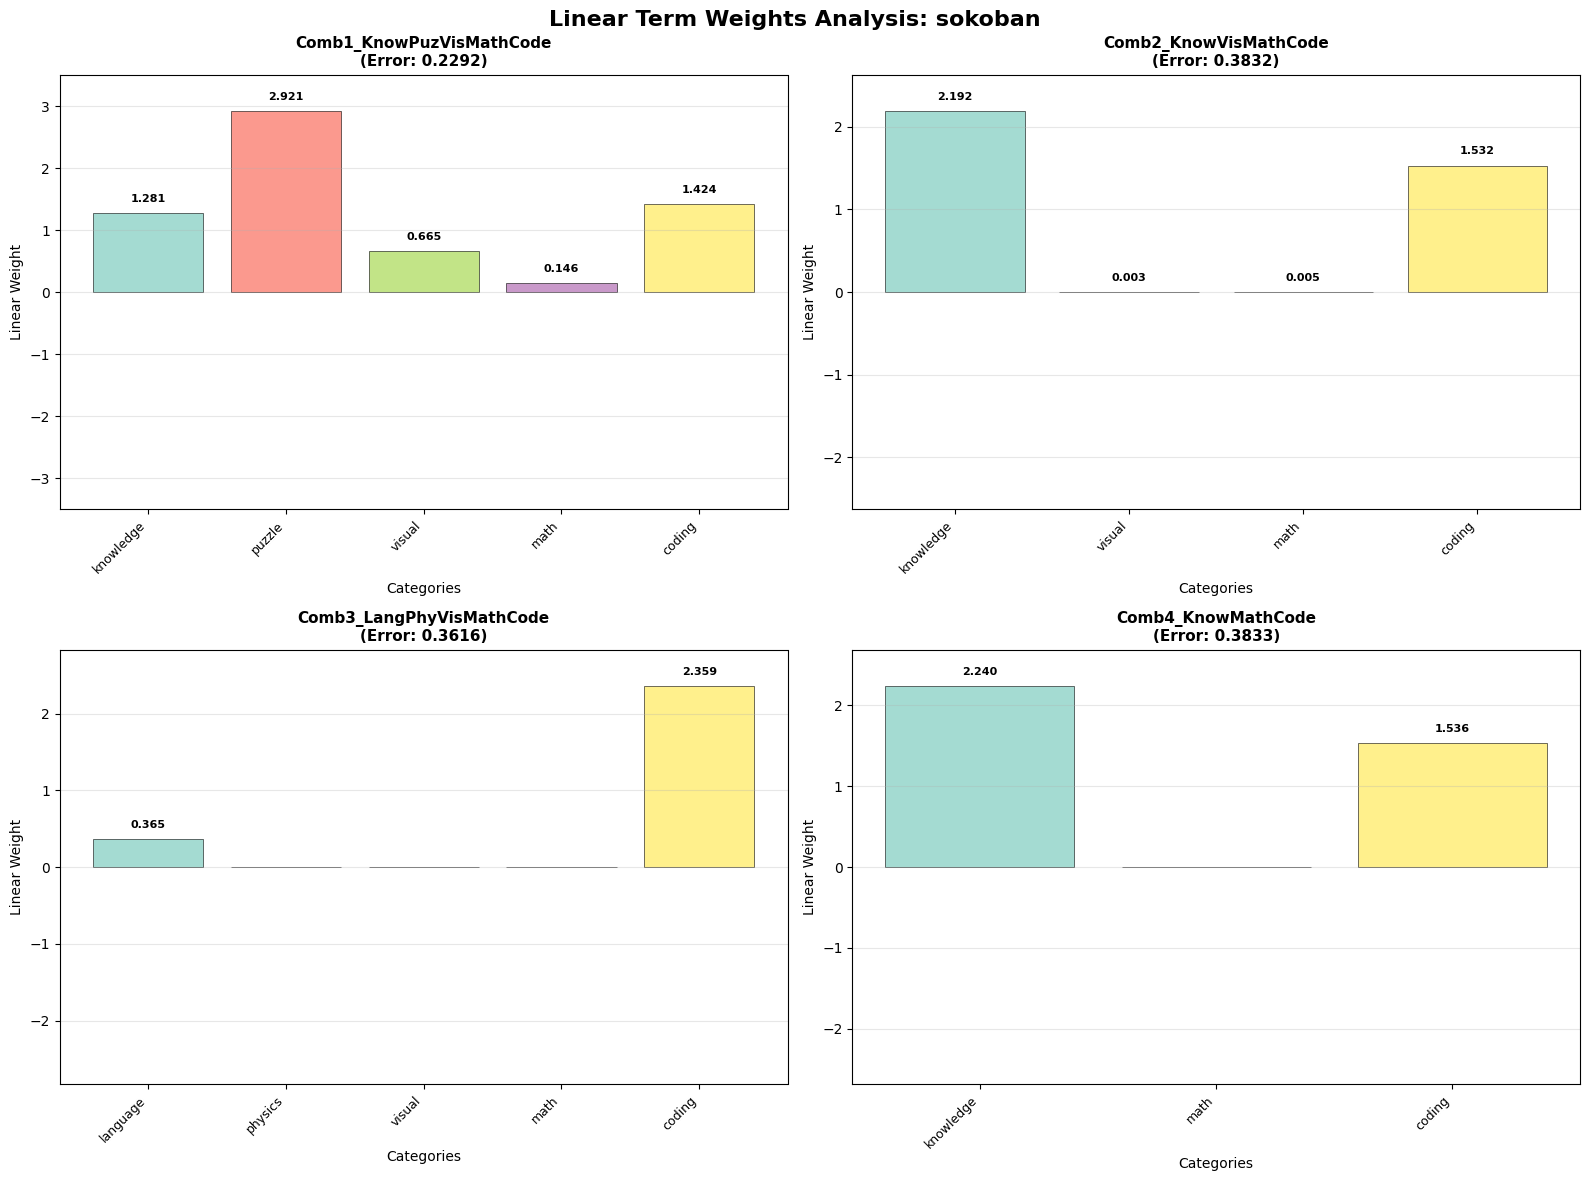

Best combination: Comb1_KnowPuzVisMathCode (Error: 0.2292)

=== Polynomial Analysis: super_mario_bros ===
  Comb1_KnowPuzVisMathCode: Error=1.3688, Categories=5
  Comb2_KnowVisMathCode: Error=1.3688, Categories=4
  Comb3_LangPhyVisMathCode: Error=1.3566, Categories=5
  Comb4_KnowMathCode: Error=1.3688, Categories=3


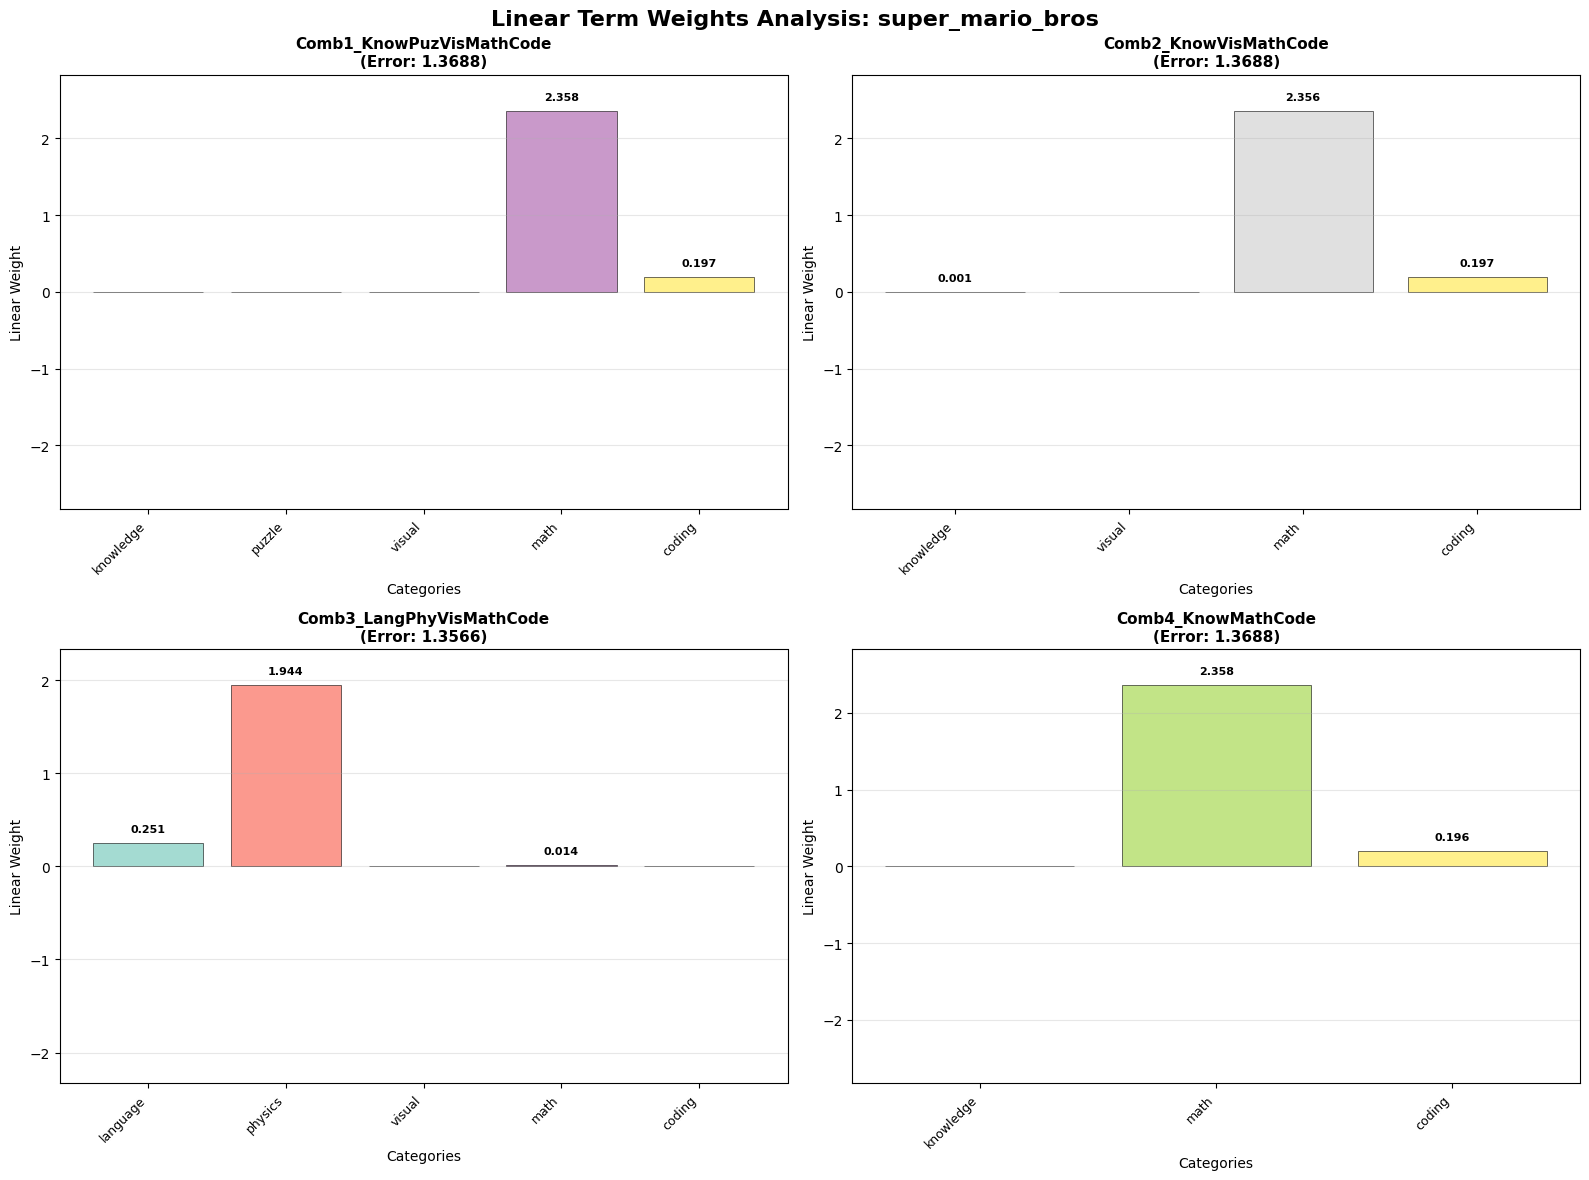

Best combination: Comb3_LangPhyVisMathCode (Error: 1.3566)

=== Polynomial Analysis: tetris ===
  Comb1_KnowPuzVisMathCode: Error=0.4366, Categories=5
  Comb2_KnowVisMathCode: Error=0.8092, Categories=4
  Comb3_LangPhyVisMathCode: Error=0.7980, Categories=5
  Comb4_KnowMathCode: Error=0.8160, Categories=3


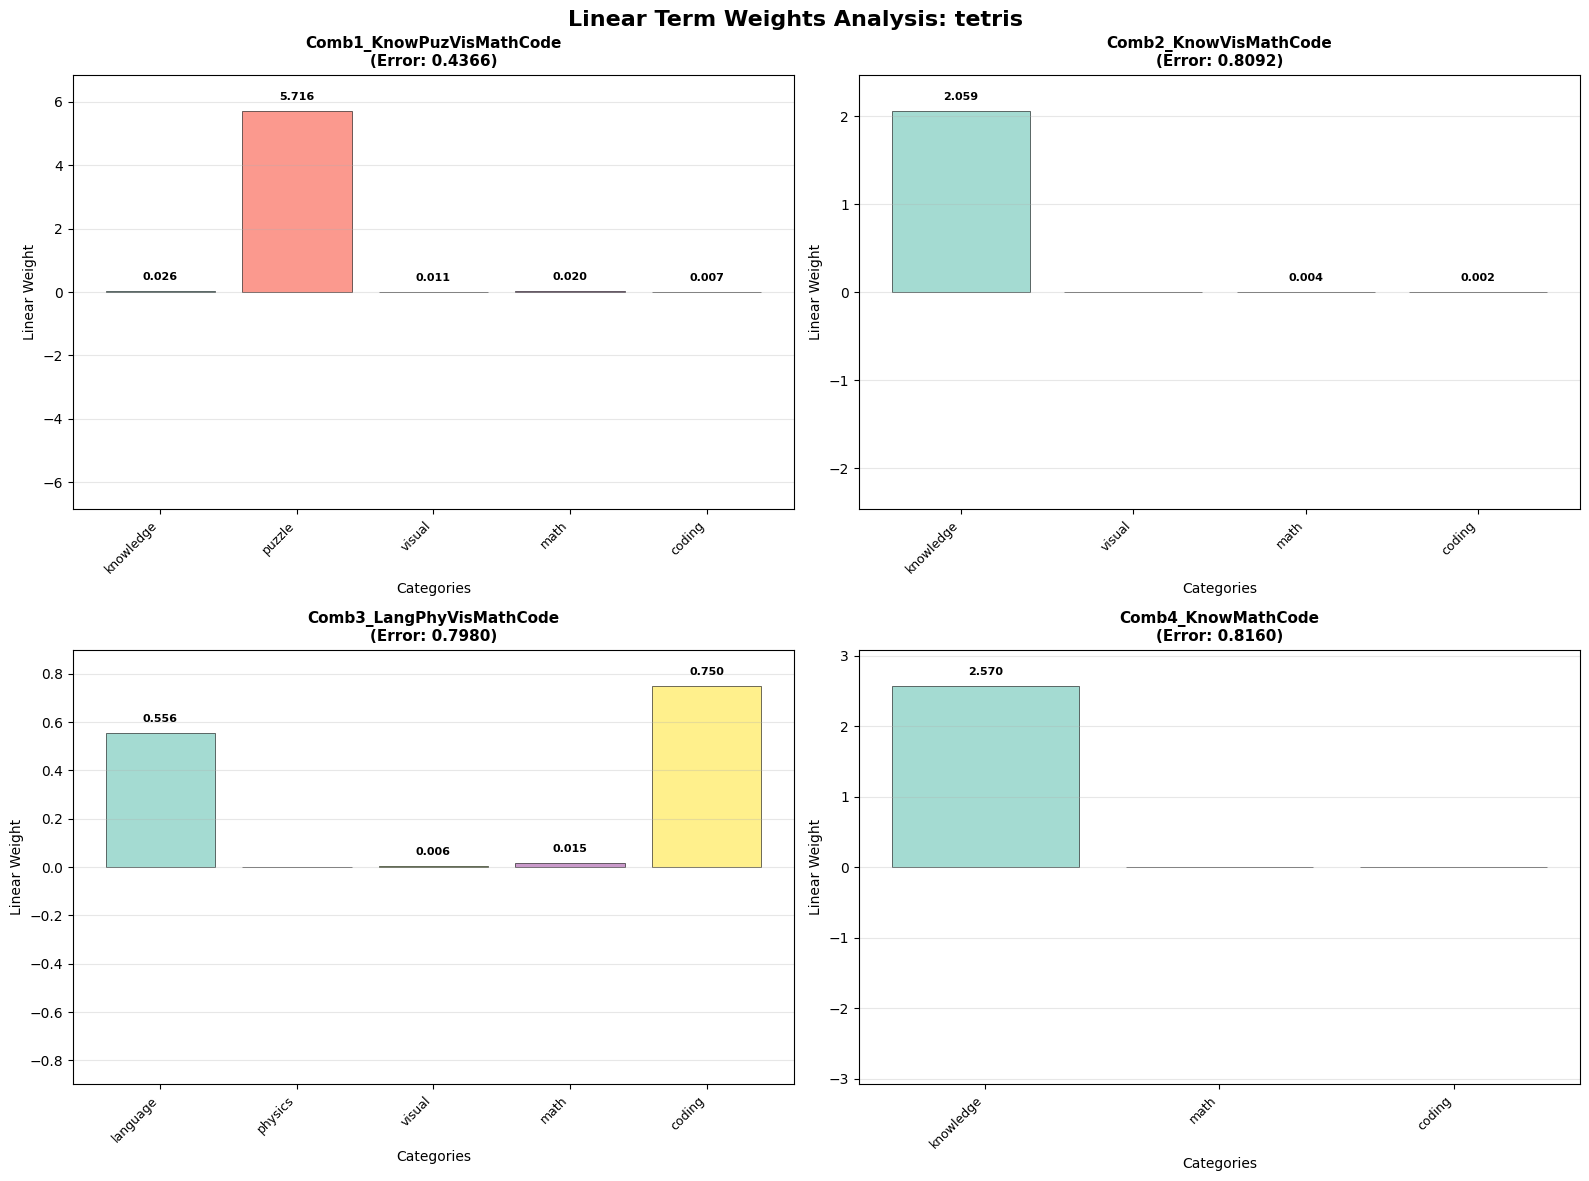

Best combination: Comb1_KnowPuzVisMathCode (Error: 0.4366)

=== Polynomial Analysis: twenty_forty_eight ===
  Comb1_KnowPuzVisMathCode: Error=0.5679, Categories=5
  Comb2_KnowVisMathCode: Error=0.9140, Categories=4
  Comb3_LangPhyVisMathCode: Error=0.8803, Categories=5
  Comb4_KnowMathCode: Error=0.9348, Categories=3


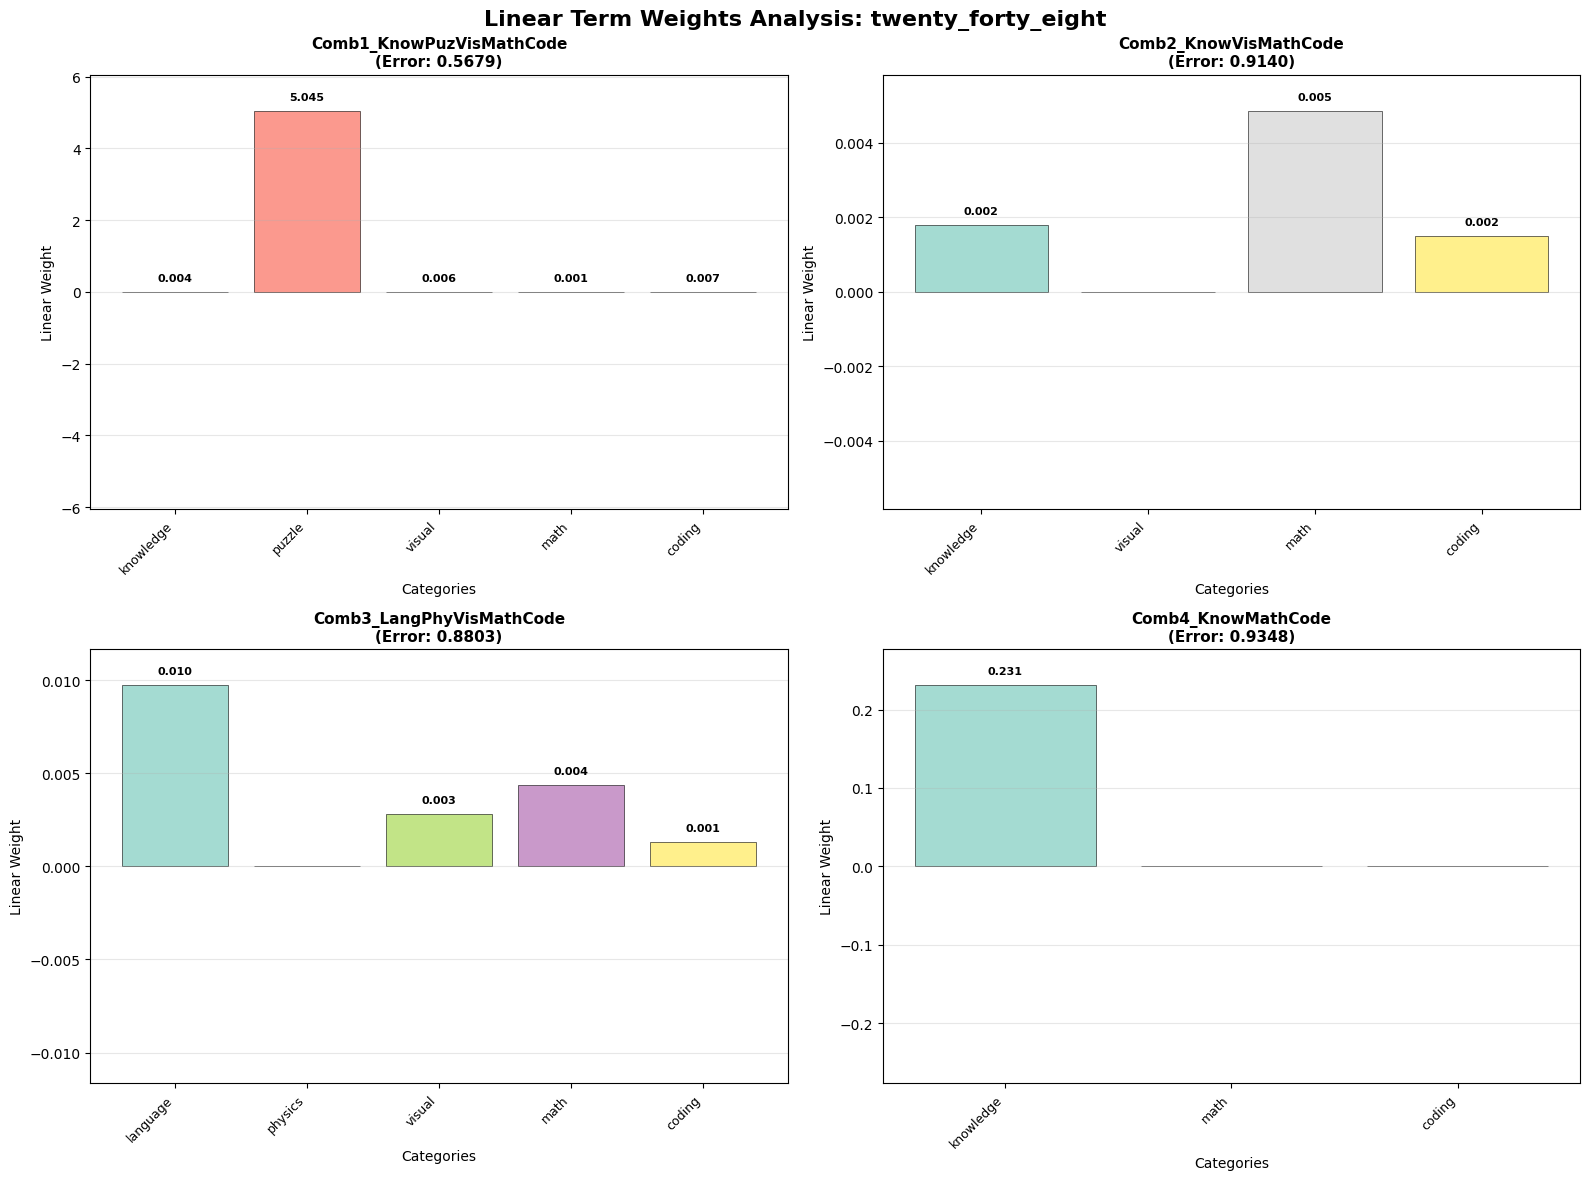

Best combination: Comb1_KnowPuzVisMathCode (Error: 0.5679)
Polynomial analysis visualization complete.


In [ ]:
# Step 1: Run polynomial analysis
poly_results = run_polynomial_analysis_notebook(
    updated_benchmark_data_df,
    OTHER_TASK_RANK_URL,
    DEFAULT_MODELS_FOR_OTHER_TASKS
)

# Step 2: Visualize results directly (no file reading needed)
visualize_polynomial_category_weights(poly_results)

## Correlation Study

We compute Spearman’s rank correlation coefficients to evaluate alignment between model performance on lmgame‑Bench and established benchmarks.(using data reported in paper)

- **t-SNE Visualization:** Projects models based on their performance patterns across both our gaming tasks and traditional benchmarks. Models with similar performance profiles cluster together, revealing which benchmark categories our games align with most closely.

- **Correlation Matrix:** Displays detailed correlations between each game and existing benchmarks. High correlation values indicate which traditional benchmarks mirror our gaming tasks in terms of model ranking.



---------- Step 1: Create DataFrame ----------

---------- Step 2: Normalize game columns ----------
Normalizing columns: ['Sokoban', 'Tetris', '2048', 'Candy Crush', 'Ace Attorney']

---------- Step 3: Generate tsne plots ----------
Generating simple t-SNE plots...
Saved t-SNE plots: tsne.png


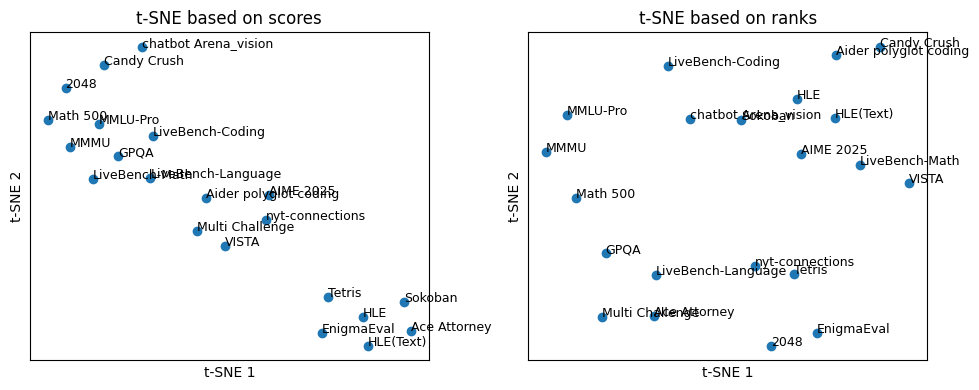

t-SNE visualization complete


In [ ]:
# Prepare existing other benchmark data
benchmark_data = {
    "MMLU-Pro": [78.4, 82.7, 84.1, 79.4, 69.1, 83.5, 85.6, 80.6],
    "GPQA": [59.1, 75.3, 80.3, 67.7, 53, 73, 83.6, 74.5],
    "HLE": [4.08, 9.04, 17.8, 5.68, 2.72, 7.96, 20.32, 18.08],
    "HLE(Text)": [4.32, 7.89, 18.38, 5.34, 2.32, 7.75, 20.57, 18.9],
    "Emma-mini Physics": [38, 65, 81, None, 44, 49, 76, 77],
    "PHYBench": [None, 15.3, 36.9, None, 7, 18, 34.8, 29.4],
    "EnigmaEval": [0.91, 4.23, 2.36, 0.58, 0.8, 5.56, 11.91, 9.21],
    "nyt-connections": [17.7, 33.6, 42.5, 19.1, 25.2, 70.8, 79.5, 68.8],
    "VISTA": [38.72, 48.23, 54.65, 38.33, 37.99, 45.25, 50.07, 51.79],
    "chatbot Arena_vision": [1183, 1208, 1379, 1185, 1126, 1231, 1302, 1265],
    "MMMU": [68.9, 76, 81.5, 72.6, 68.1, 77.7, 80.1, 79.7],
    "Math 500": [72.4, 91.6, 95.2, 85.2, 74, 90.4, 94.6, 94.2],
    "AIME 2025": [4.6, 40, 84.2, 17.5, 9.6, 69.6, 83.8, 82.7],
    "EMMA-mini Math": [30, 45, 60, None, 30, 41, 48, 56],
    "LiveBench-Math": [50.54, 79, 88.63, 60.58, 41.48, 79.28, 85, 84.9],
    "LiveBench-Coding": [73.9, 73.19, 72.87, 54.19, 69.29, 57.14, 76.71, 79.98],
    "BigCodeBench Pass@1": [30.4, 35.8, 33.1, 28.4, 31.1, 35.5, None, None],
    "Aider polyglot coding": [51.6, 64.9, 76.9, 15.6, 18.2, 61.7, 79.6, 72],
    "LiveBench-Language": [54.48, 68.27, 71.81, 49.65, 44.68, 72.15, 76, 66.05],
    "Multi Challenge": [43.2, 51.58, 49.91, 32.06, 27.81, 44.93, 56.51, 42.99],
    "Sokoban": [0, 2.3, 4.3, 0, 0, 2.3, 8, 5.3],
    # "SMB": [1267.7, 1418.7, 1498.3, 1468.7, 2047.3, 855, 3445, 1448],
    "Tetris": [14.7, 16.3, 23.3, 10.3, 14, 35, 43, 25.3],
    "2048": [108.2, 113.3, 117.3, 106.0, 106.7, 128.9, 128, 120.6],
    "Candy Crush": [106.0, 484, 416.3, 128.7, 147.3, 159, 647, 487.3],
    "Ace Attorney": [2, 7, 7, 0, 0, 16, 16, 4]
}

model_names = ["claude-3-5-sonnet-20241022", "claude-3-7-sonnet-20250219",
               "gemini-2.5-pro-preview-05-06", "llama-4-maverick-17b-128e-instruct-fp8",
               "gpt-4o-2024-11-20", "o1-2024-12-17", "o3-2025-04-16", "o4-mini-2025-04-16"]

# Step 1: Create DataFrame
print("\n---------- Step 1: Create DataFrame ----------")
benchmark_df = pd.DataFrame(benchmark_data).reset_index(drop=True)

# Step 2: Normalize game columns
print("\n---------- Step 2: Normalize game columns ----------")
columns_to_normalize = ["Sokoban", "Tetris", "2048", "Candy Crush", "Ace Attorney"]
normalized_benchmark_df = normalize_game_columns(benchmark_df, columns_to_normalize)

# Step 3: Generate tsne plots
print("\n---------- Step 3: Generate tsne plots ----------")
generate_simple_tsne_plots(benchmark_data, save_plot=True)



---------- Step 3: Generate correlation matrix ----------
Generating simple correlation matrix...
Saved correlation matrix: correlation_matrix.png


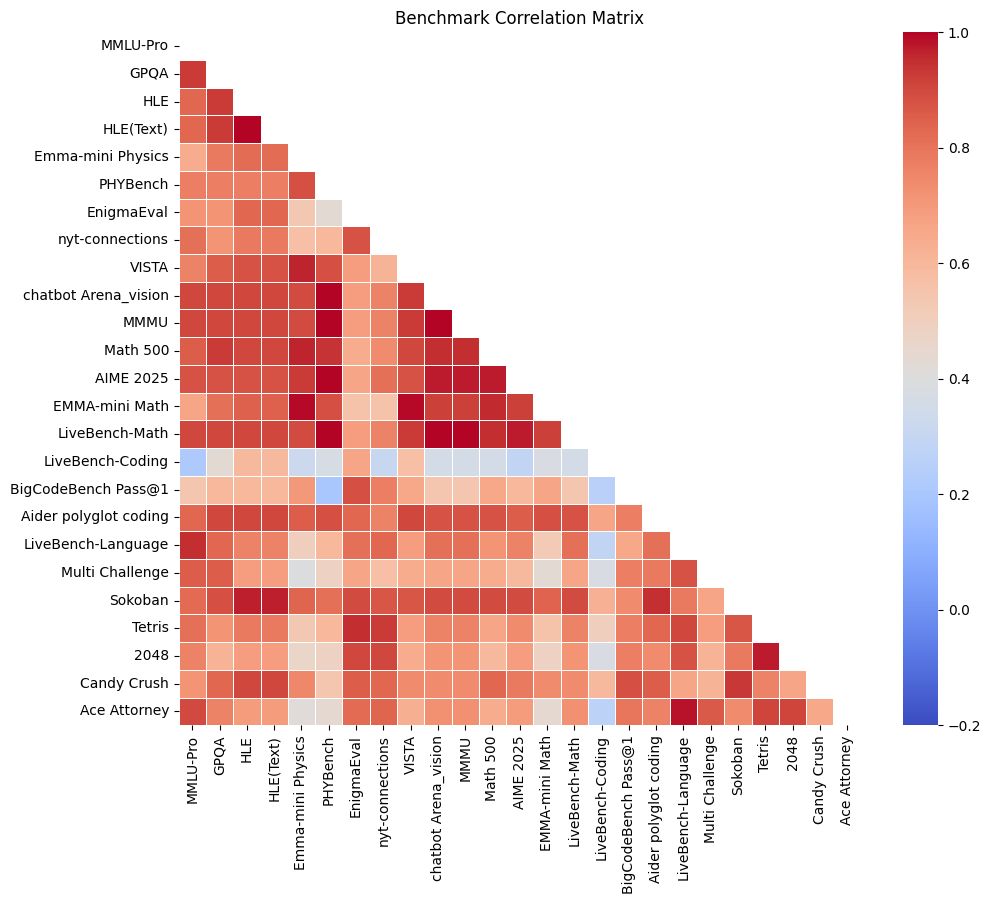

Correlation matrix complete


In [ ]:
# Step 3: Generate correlation matrix
print("\n---------- Step 3: Generate correlation matrix ----------")
generate_simple_correlation_matrix(normalized_benchmark_df, save_plot=True)



## Latent Ability Decomposition

Performs a low‑rank factorization across all benchmarks to uncover underlying capability dimensions. This analysis reveals whether our games share the same latent factors as existing benchmarks or capture unique aspects of model performance.



---------- latent factorization ----------
Generating latent factorization with 4 features...
Factorization: success=False, loss=3.4741
benchmark:
[0.42 0.00 0.15 0.43] MMLU-Pro
[0.46 0.18 0.00 0.36] GPQA
[0.48 0.29 0.15 0.08] HLE
[0.48 0.29 0.15 0.08] HLE(Text)
[0.79 0.21 0.00 0.00] Emma-mini Physics
[0.93 0.00 0.07 0.00] PHYBench
[0.16 0.29 0.46 0.09] EnigmaEval
[0.36 0.00 0.64 0.00] nyt-connections
[0.58 0.29 0.00 0.13] VISTA
[0.69 0.04 0.12 0.16] chatbot Arena_vision
[0.69 0.04 0.12 0.16] MMMU
[0.73 0.13 0.04 0.10] Math 500
[0.76 0.00 0.20 0.04] AIME 2025
[0.77 0.23 0.00 0.00] EMMA-mini Math
[0.69 0.04 0.12 0.16] LiveBench-Math
[0.10 0.75 0.05 0.09] LiveBench-Coding
[0.20 0.39 0.41 0.00] BigCodeBench Pass@1
[0.37 0.31 0.10 0.23] Aider polyglot coding
[0.25 0.00 0.29 0.46] LiveBench-Language
[0.15 0.19 0.00 0.66] Multi Challenge
[0.44 0.27 0.28 0.01] Sokoban
[0.22 0.11 0.51 0.16] Tetris
[0.22 0.03 0.60 0.14] 2048
[0.36 0.35 0.28 0.00] Candy Crush
[0.18 0.00 0.37 0.45] Ace Attorney


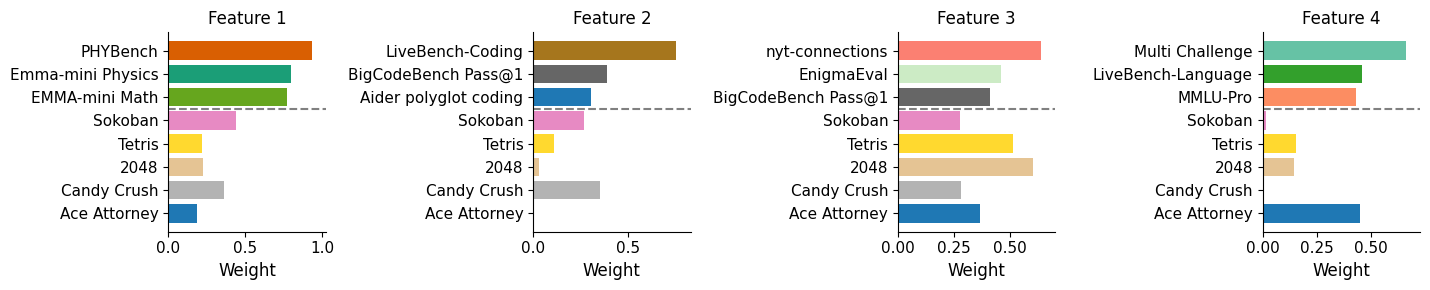

Latent factorization complete


In [ ]:
# latent factorization
print("\n---------- latent factorization ----------")
factorization_results = generate_simple_latent_factorization(
    benchmark_data, normalized_benchmark_df, feature_num=4, save_plot=True
)